In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

ModuleNotFoundError: No module named 'matplotlib'

# Data Ingestion

In [ ]:
orders = pd.read_csv('data_orders.csv')
offers = pd.read_csv('data_offers.csv')

In [ ]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [ ]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [ ]:
df_temp = offers.groupby(by = 'order_gk', as_index = False).agg(count_request = ('offer_id', 'nunique'))
df = orders.merge(df_temp , on = 'order_gk', how = 'left')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,count_request
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,3.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,6.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,3.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,NaN


# Data Wrangling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
 8   count_request                  7610 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 753.6+ KB


In [ ]:
df.isna().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
count_request                    3106
dtype: int64

In [ ]:
df.duplicated().sum()

0

# EDA

In [ ]:
orders['order_status_key'].value_counts()

order_status_key
4    7307
9    3409
Name: count, dtype: int64

In [ ]:
orders['is_driver_assigned_key'].value_counts()

is_driver_assigned_key
0    7902
1    2814
Name: count, dtype: int64

In [ ]:
df[df['cancellations_time_in_seconds'].isna()][['order_status_key', 'is_driver_assigned_key']].value_counts()

order_status_key  is_driver_assigned_key
9                 0                         3406
                  1                            3
Name: count, dtype: int64

In [ ]:
df[df['count_request'].isna()][['order_status_key', 'is_driver_assigned_key']].value_counts()

order_status_key  is_driver_assigned_key
9                 0                         1503
4                 0                         1129
                  1                          473
9                 1                            1
Name: count, dtype: int64

In [ ]:
df.loc[df['order_status_key'] == 4 , 'order_cancel_by'] = 'Client'
df.loc[df['order_status_key'] == 9 , 'order_cancel_by'] = 'System'
df.loc[df['is_driver_assigned_key'] == 1 , 'driver_assign_status'] = 'Assigned'
df.loc[df['is_driver_assigned_key'] == 0 , 'driver_assign_status'] = 'Not assigned'
df.loc[df['count_request'] == 1 , 'customer_request_status'] = '1 request'
df.loc[df['count_request'] > 1 , 'customer_request_status'] = 'Many requests'
df.loc[df['count_request'].isna() , 'customer_request_status'] = 'No request'

In [ ]:
df.groupby(by = ['order_cancel_by', 'driver_assign_status', 'customer_request_status'], as_index=False).agg(count_gk = ('order_gk','nunique')).sort_values(by = 'count_gk', ascending=False)

,order_cancel_by,driver_assign_status,customer_request_status,count_gk
4,Client,Not assigned,Many requests,2685
10,System,Not assigned,Many requests,1769
1,Client,Assigned,Many requests,1694
11,System,Not assigned,No request,1503
5,Client,Not assigned,No request,1129
3,Client,Not assigned,1 request,682
0,Client,Assigned,1 request,644
2,Client,Assigned,No request,473
9,System,Not assigned,1 request,134
6,System,Assigned,1 request,1


## Khách hủy trước/sau có tài xế? Tự hủy hay hệ thống hủy

In [ ]:
df['cancel_category'] = 'Khác'

# Khách hủy - Trước khi có tài xế
df.loc[
    (df['order_cancel_by'] == 'Client') & 
    (df['driver_assign_status'] == 'Not assigned'),
    'cancel_category'
] = 'Khách hủy – Trước khi có tài xế'

# Khách hủy - Sau khi có tài xế
df.loc[
    (df['order_cancel_by'] == 'Client') & 
    (df['driver_assign_status'] == 'Assigned'),
    'cancel_category'
] = 'Khách hủy – Sau khi có tài xế'

# Hệ thống hủy - Trước khi có tài xế
df.loc[
    (df['order_cancel_by'] == 'System') & 
    (df['driver_assign_status'] == 'Not assigned'),
    'cancel_category'
] = 'Hệ thống hủy – Trước khi có tài xế'

# Hệ thống hủy - Sau khi có tài xế
df.loc[
    (df['order_cancel_by'] == 'System') & 
    (df['driver_assign_status'] == 'Assigned'),
    'cancel_category'
] = 'Hệ thống hủy – Sau khi có tài xế'


/tmp/ipykernel_50504/3067678347.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')


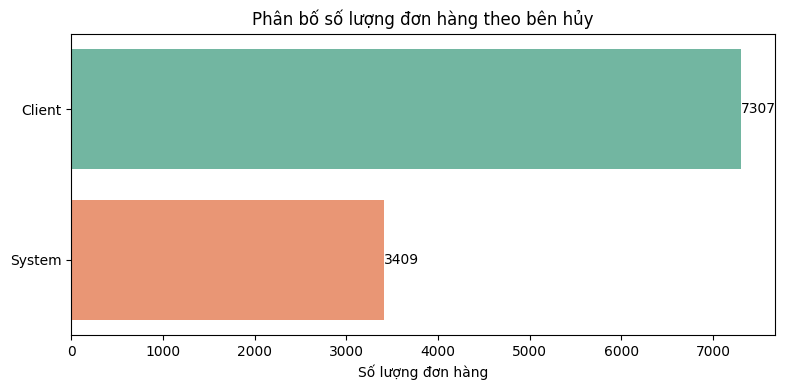

In [ ]:
failure_counts = df['order_cancel_by'].value_counts().reset_index()
failure_counts.columns = ['Lý do thất bại', 'Số lượng']

plt.figure(figsize=(8,  4))
ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')

for i in ax.containers:
    ax.bar_label(i, )

plt.title('Phân bố số lượng đơn hàng theo bên hủy')
plt.xlabel('Số lượng đơn hàng')
plt.ylabel('')

plt.tight_layout()

plt.show()

> Gần 70% chuyến bị hủy đến từ phía khách hàng

/tmp/ipykernel_50504/1886765478.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')


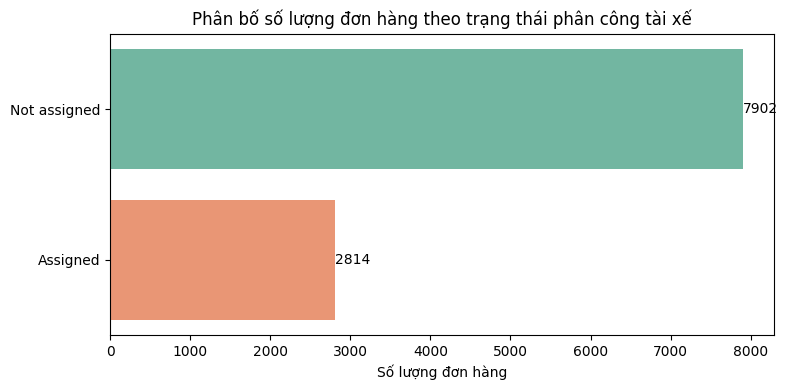

In [ ]:
failure_counts = df['driver_assign_status'].value_counts().reset_index()
failure_counts.columns = ['Lý do thất bại', 'Số lượng']

plt.figure(figsize=(8,  4))
ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')

for i in ax.containers:
    ax.bar_label(i, )

plt.title('Phân bố số lượng đơn hàng theo trạng thái phân công tài xế')
plt.xlabel('Số lượng đơn hàng')
plt.ylabel('')

plt.tight_layout()

plt.show()

> Hơn 73% chuyến bị hủy do chưa assign được tài xế

/tmp/ipykernel_50504/1803180827.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')


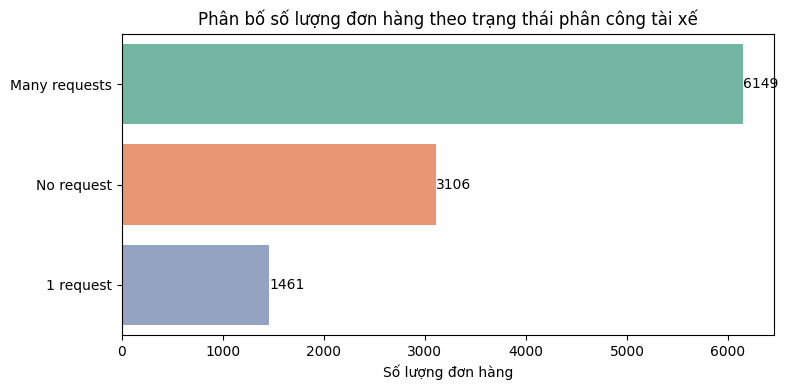

In [ ]:
failure_counts = df['customer_request_status'].value_counts().reset_index()
failure_counts.columns = ['Lý do thất bại', 'Số lượng']

plt.figure(figsize=(8,  4))
ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')

for i in ax.containers:
    ax.bar_label(i, )

plt.title('Phân bố số lượng đơn hàng theo trạng thái phân công tài xế')
plt.xlabel('Số lượng đơn hàng')
plt.ylabel('')

plt.tight_layout()

plt.show()

> Hơn 57% lượng đơn hủy vì khách hàng request rất nhiều lần

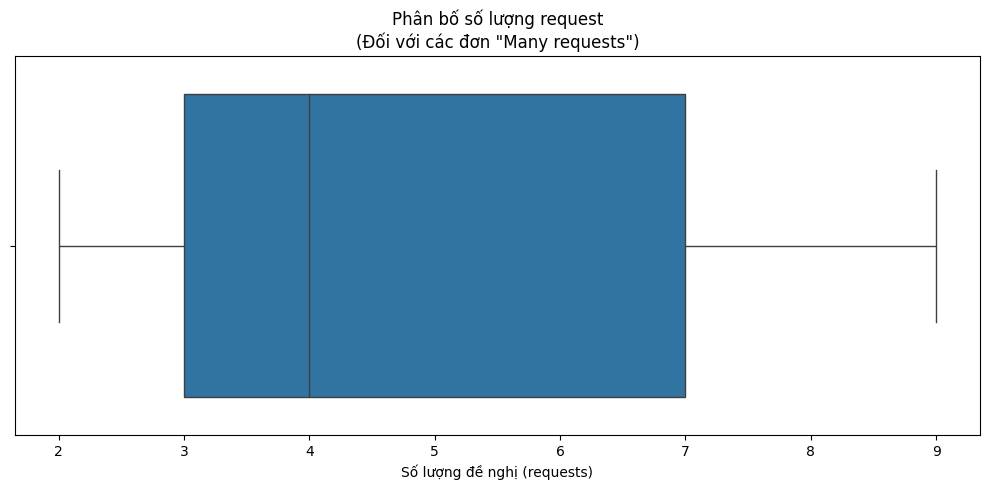

In [ ]:
plt.figure(figsize=(10, 5))

sns.boxplot(data = df[df['customer_request_status']== 'Many requests']
            , x = 'count_request')

plt.title('Phân bố số lượng request\n(Đối với các đơn "Many requests")'),
plt.xlabel('Số lượng đề nghị (requests)')

plt.tight_layout()
plt.show()

> Với những đơn có nhiều request:

- Giá trị trung vị (median) nằm khoảng 3–4 -> Phần lớn các đơn được gửi đến khoảng 3–4 requests trước khi bị hủy.

- Phân vị thứ nhất (Q1) gần 1–2, phân vị thứ ba (Q3) khoảng 6–7 -> cho thấy phân bố trải rộng.

- Có đơn cần gửi 8–9 lần mà vẫn chưa có tài xế nhận -> Đây có vẻ là ngưỡng cao nhất của hệ thống.

## Kết hợp 2 yếu tố

/tmp/ipykernel_50504/1546925525.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')


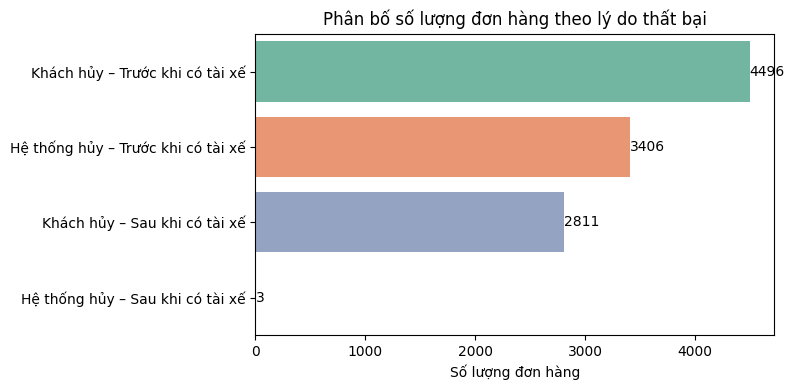

In [ ]:
# Đếm số lượng theo từng lý do
failure_counts = df['cancel_category'].value_counts().reset_index()
failure_counts.columns = ['Lý do thất bại', 'Số lượng']

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')

for i in ax.containers:
    ax.bar_label(i, )

plt.title('Phân bố số lượng đơn hàng theo lý do thất bại')
plt.xlabel('Số lượng đơn hàng')
plt.ylabel('')

plt.tight_layout()

plt.show()

## Đào sâu, trước khi có tài xế thì khách hàng có request nhiều không

In [ ]:
# Tạo 'failure_group'
df['failure_group'] = 'Khác'  # gán giá trị mặc định

# 1. Khách hủy - Không gửi request nào
df.loc[
    (df['order_cancel_by'] == 'Client') &
    (df['driver_assign_status'] == 'Not assigned') &
    (df['customer_request_status'] == 'No request'),
    'failure_group'
] = 'Khách hủy - Không request'

# 2. Khách hủy - Gửi nhiều request nhưng không có tài xế
df.loc[
    (df['order_cancel_by'] == 'Client') &
    (df['driver_assign_status'] == 'Not assigned') &
    (df['customer_request_status'] == 'Many requests'),
    'failure_group'
] = 'Khách hủy - Nhiều request (chưa có tài xế)'

# 3. Khách hủy - Gửi 1 request nhưng không ai nhận
df.loc[
    (df['order_cancel_by'] == 'Client') &
    (df['driver_assign_status'] == 'Not assigned') &
    (df['customer_request_status'] == '1 request'),
    'failure_group'
] = 'Khách hủy - 1 request (chưa có tài xế)'

# 4. Khách hủy - Đã có tài xế
df.loc[
    (df['order_cancel_by'] == 'Client') &
    (df['driver_assign_status'] == 'Assigned'),
    'failure_group'
] = 'Khách hủy sau khi có tài xế'

# 5. Hệ thống hủy - Không gửi request nào
df.loc[
    (df['order_cancel_by'] == 'System') &
    (df['driver_assign_status'] == 'Not assigned') &
    (df['customer_request_status'] == 'No request'),
    'failure_group'
] = 'Hệ thống hủy - Không request'

# 6. Hệ thống hủy - Gửi 1 hoặc nhiều request nhưng không ai nhận
df.loc[
    (df['order_cancel_by'] == 'System') &
    (df['driver_assign_status'] == 'Not assigned') &
    (df['customer_request_status'].isin(['1 request', 'Many requests'])),
    'failure_group'
] = 'Hệ thống hủy - Có request nhưng không ai nhận'

# 7. Hệ thống hủy - Đã có tài xế
df.loc[
    (df['order_cancel_by'] == 'System') &
    (df['driver_assign_status'] == 'Assigned'),
    'failure_group'
] = 'Hệ thống hủy sau khi có tài xế'

/tmp/ipykernel_50504/2305162478.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')


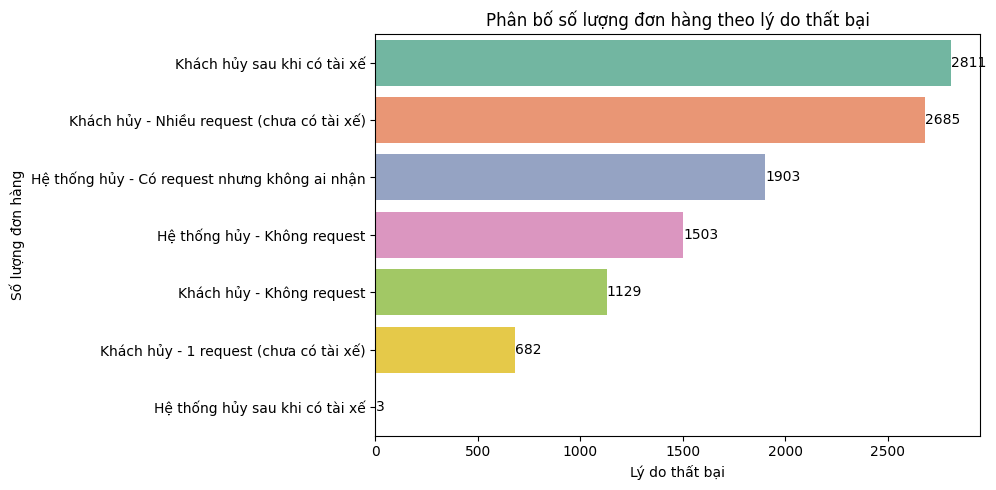

In [ ]:
# Đếm số lượng theo từng lý do
failure_counts = df['failure_group'].value_counts().reset_index()
failure_counts.columns = ['Lý do thất bại', 'Số lượng']

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=failure_counts, y='Lý do thất bại', x='Số lượng', palette='Set2')

for i in ax.containers:
    ax.bar_label(i, )

plt.title('Phân bố số lượng đơn hàng theo lý do thất bại')
plt.ylabel('Số lượng đơn hàng')
plt.xlabel('Lý do thất bại')

plt.tight_layout()

plt.show()

> "Khách hủy trước khi có tài xế" dẫn đầu với 2.811 đơn

⟶ Điều này cho thấy dù hệ thống đã gán tài xế thành công, khách vẫn quyết định huỷ → có thể do ETA quá lâu, tài xế không di chuyển/di chuyển đoạn đường xa mà khách không đợi được, hoặc thay đổi ý định...

> "Khách hủy – Nhiều request (chưa có tài xế)" (2.685 đơn)

⟶ Hệ thống đã gửi nhiều đề nghị nhưng không tài xế nào nhận → dấu hiệu matching thất bại hoặc thiếu tài xế.

> "Hệ thống hủy – Có request nhưng không ai nhận" (1.903 đơn)

⟶ Matching tự động thất bại sau khi gửi đi → đây là vấn đề hệ thống rõ ràng cần cải thiện.

# Vẽ biểu đồ phân bố các đơn hàng thất bại theo giờ. Xem xét liệu có khoảng giờ nhất định nào có tỷ lệ cao bất thường của một hạng mục này hay hạng mục khác không? Những giờ nào là thất bại nhiều nhất? Điều này có thể được giải thích như thế nào?

In [ ]:
# Bước 1: Làm sạch và tạo cột 'hour' từ 'order_datetime'
df['order_datetime'] = pd.to_datetime(df['order_datetime'], format='%H:%M:%S', errors='coerce')
df['hour'] = df['order_datetime'].dt.hour
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,count_request,order_cancel_by,driver_assign_status,customer_request_status,cancel_category,failure_group,hour
0,1900-01-01 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1.0,Client,Assigned,1 request,Khách hủy – Sau khi có tài xế,Khách hủy sau khi có tài xế,18
1,1900-01-01 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,3.0,Client,Not assigned,Many requests,Khách hủy – Trước khi có tài xế,Khách hủy - Nhiều request (chưa có tài xế),20
2,1900-01-01 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,6.0,Client,Assigned,Many requests,Khách hủy – Sau khi có tài xế,Khách hủy sau khi có tài xế,12
3,1900-01-01 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,3.0,Client,Assigned,Many requests,Khách hủy – Sau khi có tài xế,Khách hủy sau khi có tài xế,13
4,1900-01-01 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,NaN,System,Not assigned,No request,Hệ thống hủy – Trước khi có tài xế,Hệ thống hủy - Không request,21


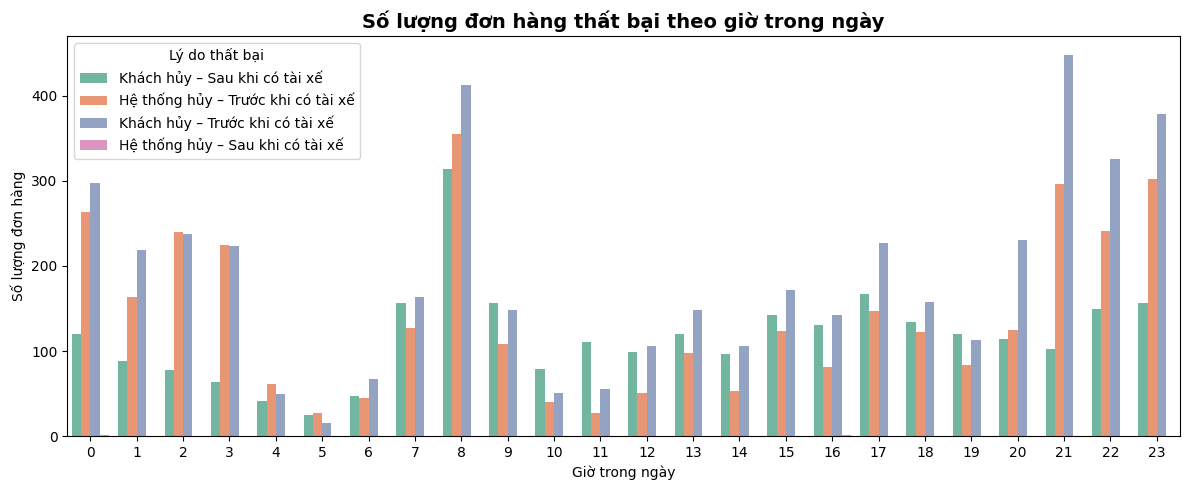

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='hour', hue='cancel_category', palette='Set2')
plt.title('Số lượng đơn hàng thất bại theo giờ trong ngày', fontsize=14, weight='bold')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượng đơn hàng')
plt.legend(title='Lý do thất bại')
plt.tight_layout()
plt.show()

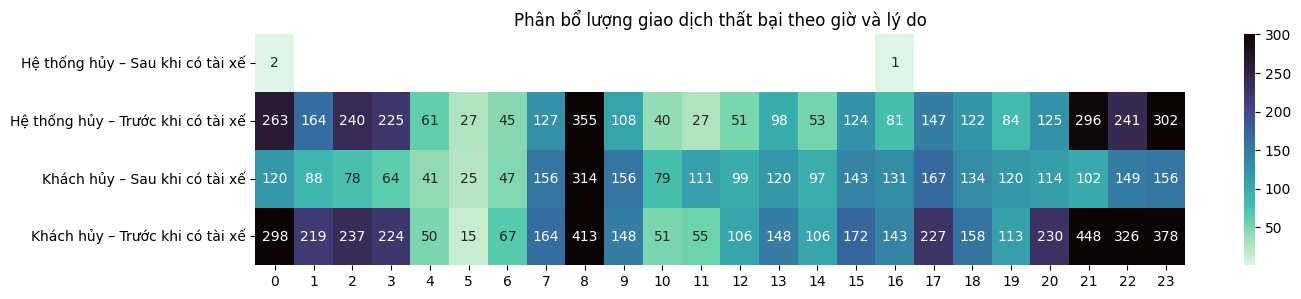

In [ ]:
cancel_result_heatmap = df.pivot_table(columns='hour'
               , index = 'cancel_category'
               , values = 'order_gk'
               , aggfunc= 'nunique')

plt.figure(figsize = (15,3))

sns.heatmap(data = cancel_result_heatmap
            , cmap = 'mako_r'
            , fmt = 'g'
            , annot=True
            , vmax=300)

plt.title('Phân bổ lượng giao dịch thất bại theo giờ và lý do')
plt.xlabel('')
plt.ylabel('')

plt.show()

> Với từng nhóm lí do:
-  Trước khi có tài xế: khách hoặc hệ thống hủy thường tập trung vào khung giờ 8H sáng (giờ đi làm theo văn phòng) và từ 21H đêm - 0H sáng hôm sau

- Sau khi có tài xế:

    + Hệ thống hầu như không hủy

    + Khách chủ động hủy vào khung 8H sáng ==> **cao bất thường** ==> Đào thêm về mối tương quan giữa `m_order_eta` và `cancellations_time_in_seconds`

In [ ]:
# Phân loại thêm tình trạng muộn theo việc estimate và reality của thời gian chờ đợi
df.loc[(df['m_order_eta'] < df['cancellations_time_in_seconds'])&(df['m_order_eta'].notnull()), 'after_driver_assign_status'] = 'Cancel - Driver was late'
df.loc[(df['m_order_eta'] >= df['cancellations_time_in_seconds'])&(df['m_order_eta'].notnull()), 'after_driver_assign_status'] = 'Cancel - Customer cant that long'

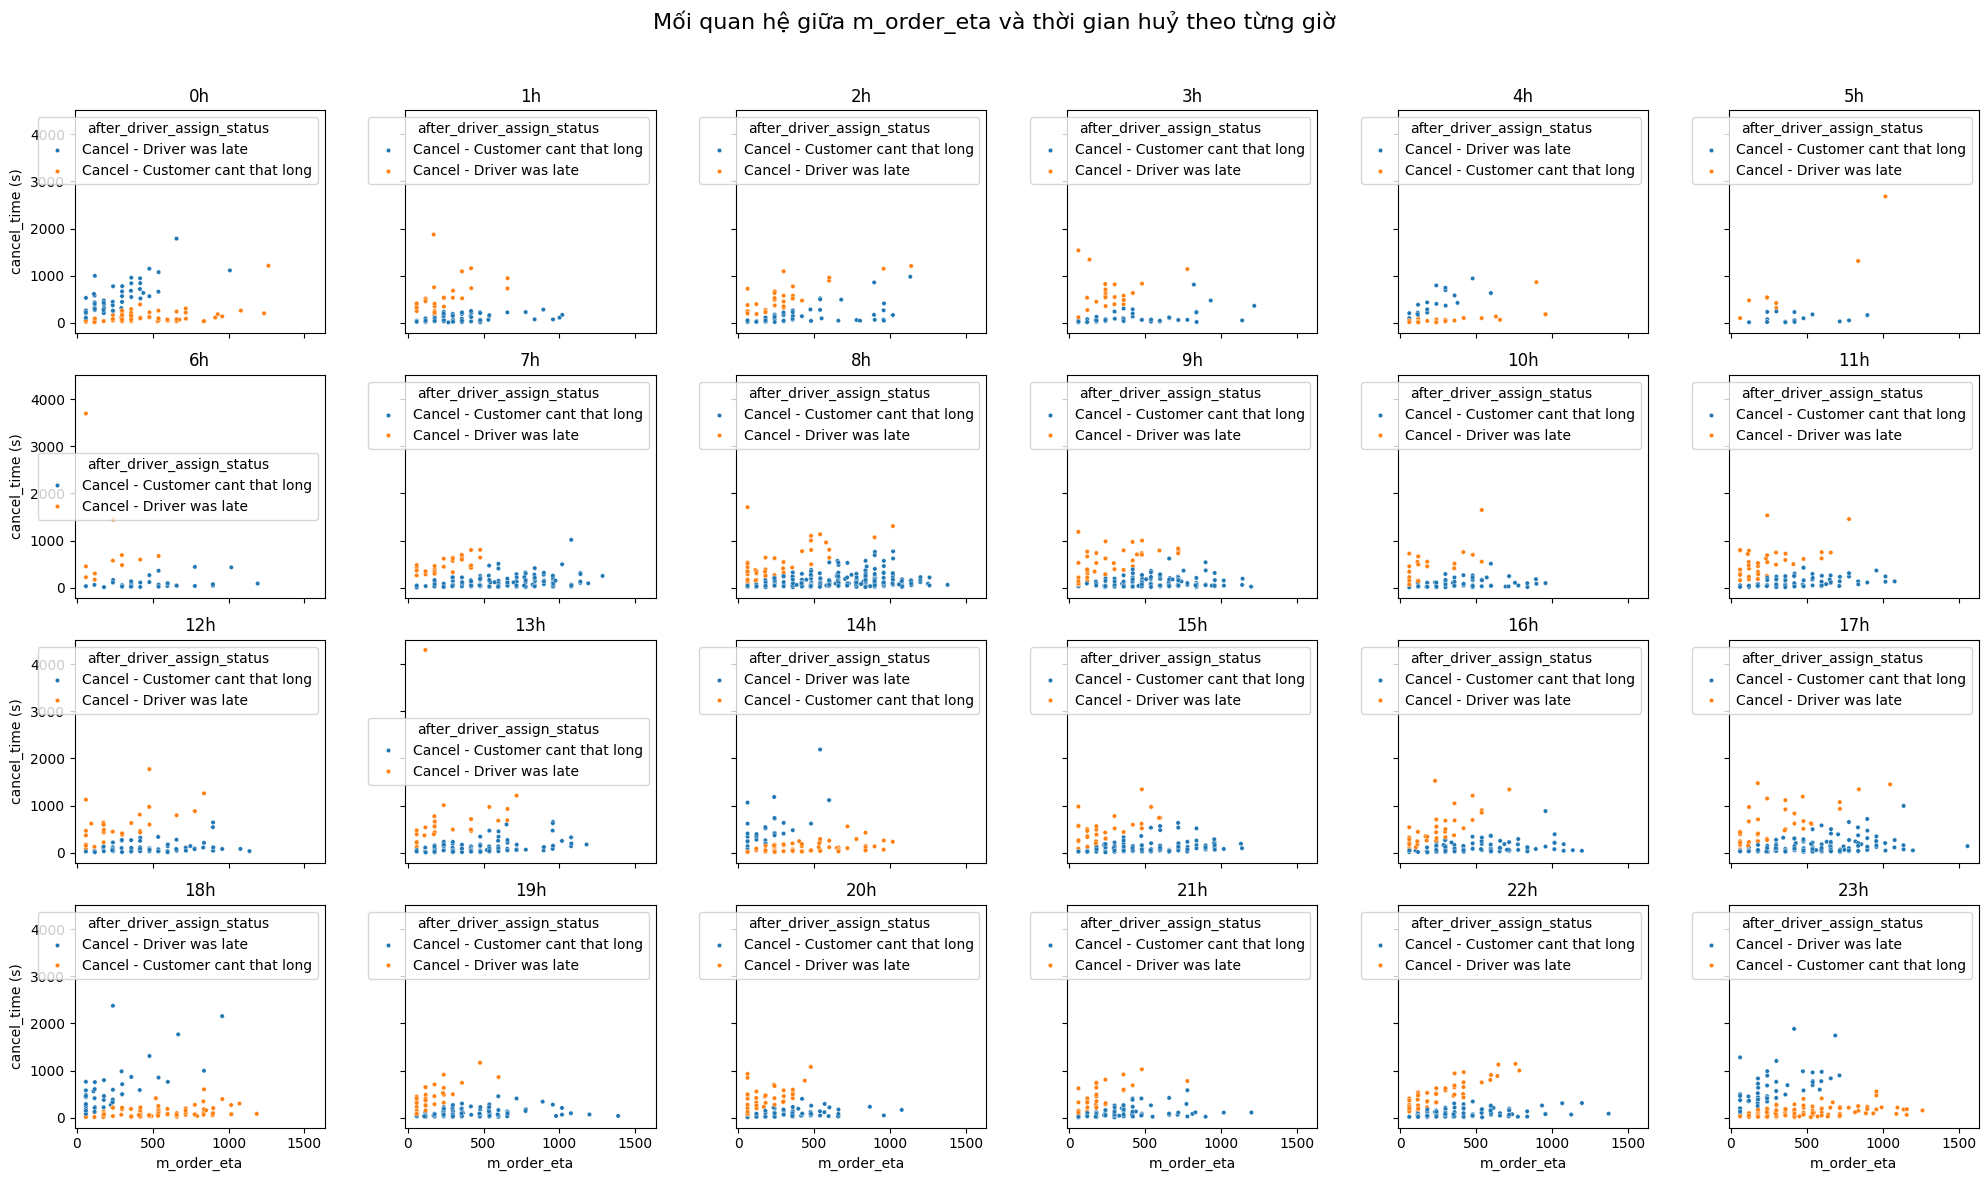

In [ ]:
fig, axes = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle('Mối quan hệ giữa m_order_eta và thời gian huỷ theo từng giờ', fontsize=16)

for hour in range(24):
    ax = axes[hour // 6, hour % 6]
    hour_df = df[df['hour'] == hour]
    sns.scatterplot(data=hour_df,
                    x='m_order_eta',
                    y='cancellations_time_in_seconds',
                    hue = 'after_driver_assign_status', 
                    ax=ax,
                    s=10)
    ax.set_title(f'{hour}h')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(6):
    axes[3, i].set_xlabel('m_order_eta')
for i in range(4):
    axes[i, 0].set_ylabel('cancel_time (s)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


> Với hành vi hủy của khách hàng, nhìn chung:

- Khách hàng đã phần sẽ hủy sau 1000 giây (~16 phút) kể từ khi tìm được tài xế và thời gian 

- Vào khung 8h sáng, phần lớn họ hủy vì không thể đợi được quá lâu (ETA cao) => Khung giờ cao điểm đi làm nên doanh nghiệp cần xử lý phân phối tốt hơn

- Vào khung 23H-0H sáng, khách hủy vì tài xế đến quá muộn => Khung giờ này nửa đêm khó kiếm tài xế

/tmp/ipykernel_50504/1608433532.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df[df['hour'] == 8]


<Axes: xlabel='m_order_eta', ylabel='cancellations_time_in_seconds'>

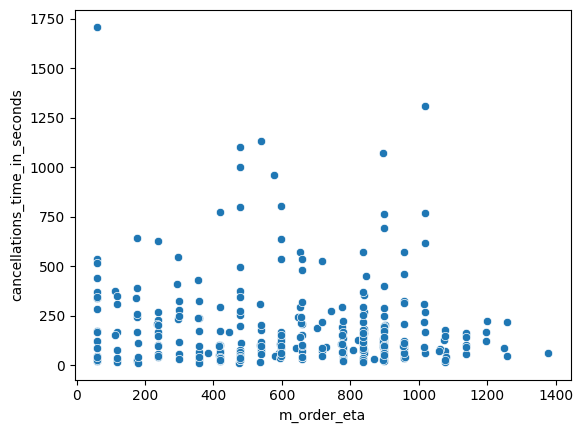

In [ ]:
zzz

/tmp/ipykernel_2459/3987960985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancel_data['driver_status'] = cancel_data['is_driver_assigned_key'].map({0: 'Chưa có tài xế', 1: 'Đã có tài xế'})


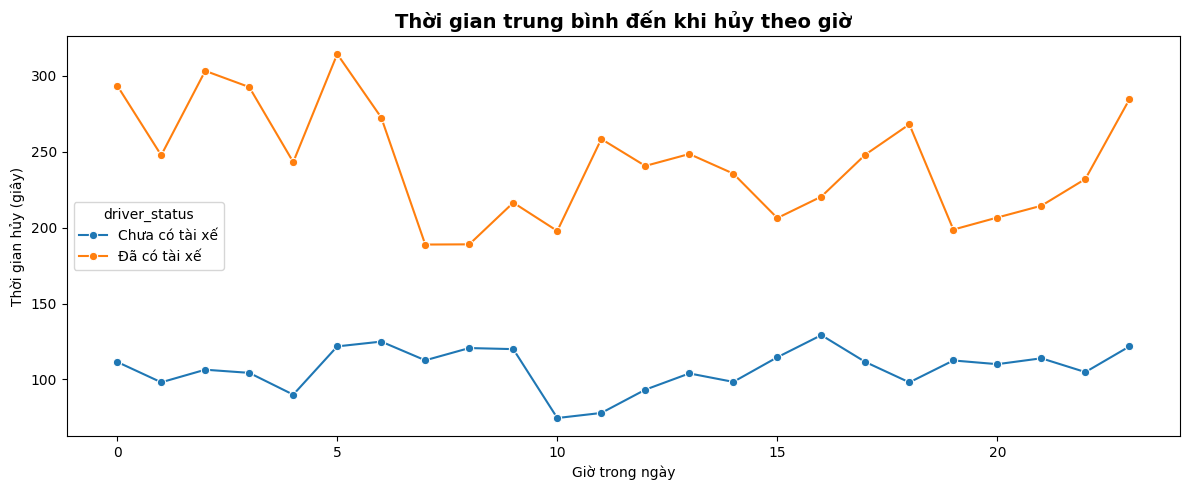

In [ ]:
cancel_data = df.dropna(subset=['cancellations_time_in_seconds'])
cancel_data['driver_status'] = cancel_data['is_driver_assigned_key'].map({0: 'Chưa có tài xế', 1: 'Đã có tài xế'})
cancel_avg = cancel_data.groupby(['hour', 'driver_status'])['cancellations_time_in_seconds'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=cancel_avg, x='hour', y='cancellations_time_in_seconds', hue='driver_status', marker='o')
plt.title('Thời gian trung bình đến khi hủy theo giờ', fontsize=14, weight='bold')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Thời gian hủy (giây)')
plt.tight_layout()
plt.show()

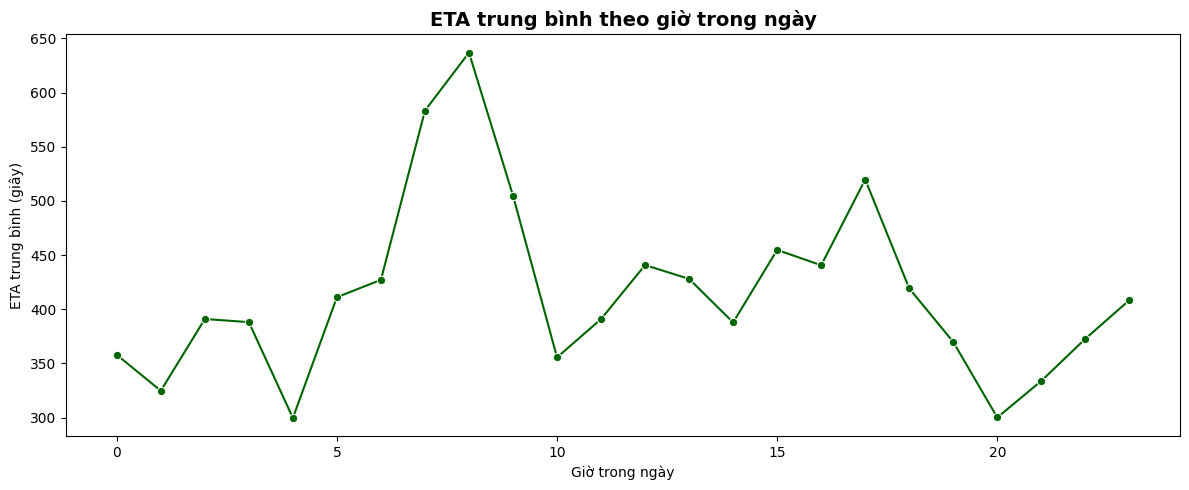

In [ ]:
eta_data = df.dropna(subset=['m_order_eta'])
eta_avg = eta_data.groupby('hour')['m_order_eta'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=eta_avg, x='hour', y='m_order_eta', marker='o', color='darkgreen')
plt.title('ETA trung bình theo giờ trong ngày', fontsize=14, weight='bold')
plt.xlabel('Giờ trong ngày')
plt.ylabel('ETA trung bình (giây)')
plt.tight_layout()
plt.show()